# Learning curve for AlexNet
purpose: test whether attentional effects can be explained by not enough training data

In [1]:
from glob import glob

import joblib
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import searchstims

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


## munge data

In [2]:
gz_filename = '../../../data/experiment_6_learn_curve_VGG16/data_prepd_for_nets/spatial_config_search_vgg16_data.gz'

data_dict = joblib.load(gz_filename)
y_test = data_dict['y_test']

In [5]:
TRAIN_SIZE_LIST = [1200, 3200, 6200, 8000, 10000, 12000]
NUMBER_NETS_TO_TRAIN = 5

train_size_gz_map = {}
results_gz_filenames = []
for train_size in TRAIN_SIZE_LIST:
    results_gz_filename = f'../../../data/experiment_6_learn_curve_VGG16/results/spatial_config_search_vgg16_models/test_VGG16_{train_size}_train_samples_400_epochs.gz'
    results_gz_filenames.append(results_gz_filename)
    train_size_gz_map[train_size] = results_gz_filename

In [6]:
acc_scatter = np.zeros(shape=(len(TRAIN_SIZE_LIST), NUMBER_NETS_TO_TRAIN))

for train_size_ind, results_fname in enumerate(results_gz_filenames):
    results = joblib.load(results_fname)
    preds_per_model = results['predictions_per_model_dict']
    for model_ind, (key, preds) in enumerate(preds_per_model.items()):
        acc_per_model = np.sum(preds == y_test) / y_test.shape[0]
        acc_scatter[train_size_ind, model_ind] = acc_per_model

mn_acc = np.mean(acc_scatter, axis=1)

In [7]:
y_test_set_sizes = data_dict['set_size_vec_test']

In [8]:
SET_SIZES = [1, 2, 4, 8]

acc_by_set_size_dict = {}
for set_size in SET_SIZES:
    
    inds_this_set_size = np.where(y_test_set_sizes == set_size)[0]
    y_test_this_set_size = y_test[inds_this_set_size]

    acc_scatter_this_set_size = np.zeros(shape=(len(TRAIN_SIZE_LIST), NUMBER_NETS_TO_TRAIN))

    for train_size_ind, results_fname in enumerate(results_gz_filenames):
        
        results = joblib.load(results_fname)
        preds_per_model = results['predictions_per_model_dict']
                
        for model_ind, (key, preds) in enumerate(preds_per_model.items()):
            preds_this_set_size = preds[inds_this_set_size]
            acc_per_model = np.sum(preds_this_set_size == y_test_this_set_size) / y_test_this_set_size.shape[0]
            acc_scatter_this_set_size[train_size_ind, model_ind] = acc_per_model

    mn_acc_this_set_size = np.mean(acc_scatter_this_set_size, axis=1)
    
    scatter_mn_this_set_size = {
        'acc_scatter': acc_scatter_this_set_size,
        'mn_acc': mn_acc_this_set_size,
    }
    
    acc_by_set_size_dict[set_size] = scatter_mn_this_set_size

## make plot

In [9]:
mpl.style.use('bmh')

plt.rcParams['font.size'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.labelweight'] = 'regular'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20

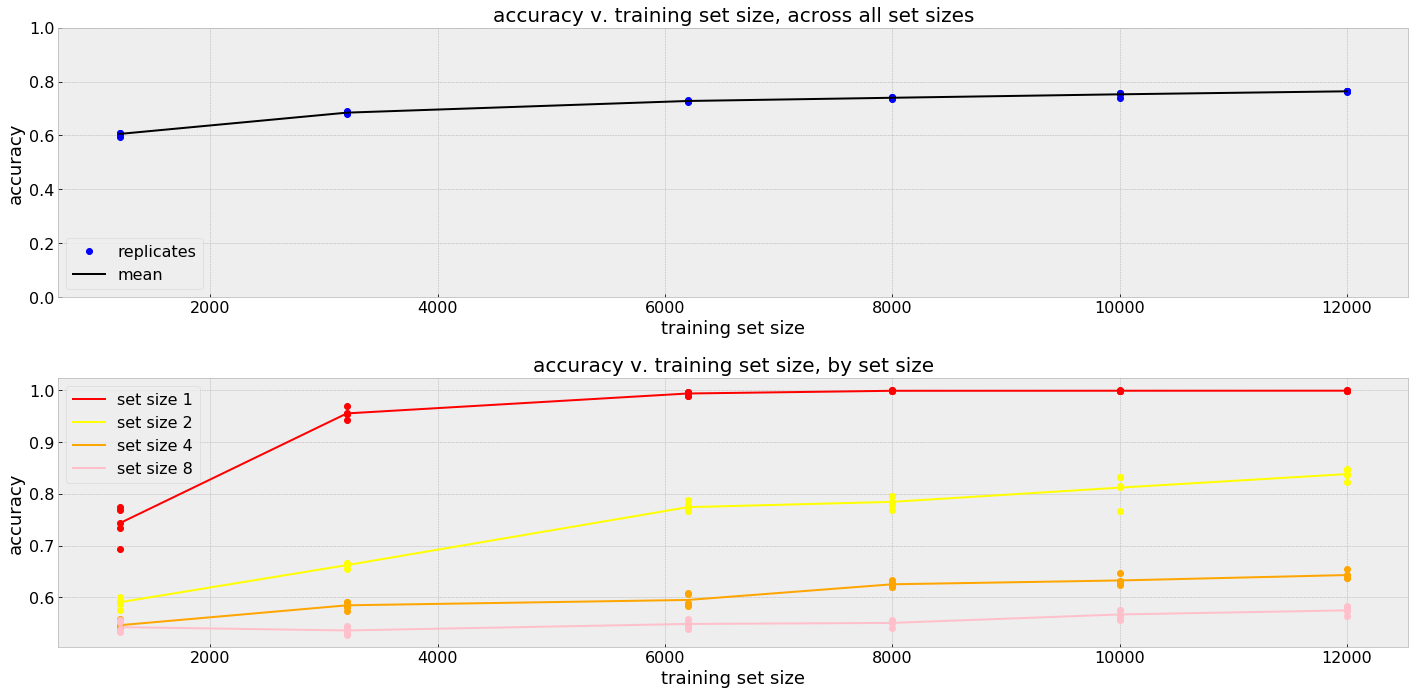

In [11]:
fig, ax = plt.subplots(2, 1)
ax = ax.ravel()
fig.set_size_inches(20,10)

ax[0].plot(TRAIN_SIZE_LIST, acc_scatter, linestyle='None', marker='o', color='blue', label='replicates');
ax[0].plot(TRAIN_SIZE_LIST, mn_acc, color='black', label='mean')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('training set size')
ax[0].set_ylim([0.0, 1.0])
ax[0].set_title('accuracy v. training set size, across all set sizes')

# https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
handles, labels = ax[0].get_legend_handles_labels()
handle_list, label_list = [], []
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)

ax[0].legend(handle_list, label_list, loc='lower left')

color = ['red', 'yellow', 'orange', 'pink']
for set_size, clr in zip(SET_SIZES, color):
    ax[1].plot(TRAIN_SIZE_LIST, acc_by_set_size_dict[set_size]['acc_scatter'], color=clr, linestyle='None', marker='o')
    ax[1].plot(TRAIN_SIZE_LIST, acc_by_set_size_dict[set_size]['mn_acc'], color=clr, label=f'set size {set_size}')

ax[1].set_title('accuracy v. training set size, by set size')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('training set size')
ax[1].legend(loc='upper left')

plt.tight_layout();
plt.savefig('vgg16-spatial-learn-curve.png')